# Information Retrieval Project - MobileNet model implementation
## COVID-19 Search Engine (P12)

Content-based image retrieval (CBIR) is a computer vision technique which addresses the problem of searching for digital images in large databases. A content-based approach exploits the contents of an image, such as colors, shapes and textures, differing from its concept-based counterpart, which instead focuses on keywords and tags associated with the image itself.

Image retrieval has gained more and more relevance in the medical field, due to the accumulation of extensive collections of scans in hospitals. These images are stored in DICOM format, which must be manually annotated and may require considerable time to process by physicians. The goal of this project is trying to address this problem by considering different approaches for building a content-based medical image retrieval system and comparing their results based on classification metrics and computational time.

# Installation of Requirements

This part of the code installs necessary dependencies specified in the `requirements.txt` file.
Utilizes the `!pip install -r requirements.txt` command to install packages listed in the `requirements.txt` file. This ensures that all required dependencies are installed before proceeding with execution.


In [ ]:
!pip install -r requirements.txt

# Importing Required Libraries

This part of the code imports necessary libraries.

In [2]:
# Import
import os
import time
import glob
import kaggle

import keras
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

from keras.models import Model
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet import MobileNet, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

from matplotlib import pyplot as plt
from PIL import Image, UnidentifiedImageError

# Definition of constants

This part of the code defines useful constants and paths.

In [3]:
# ************************************** #
# ************** CONSTANTS ************* #
# ************************************** #

# PATHS
PROJECT_ROOT = os.getcwd()  # The project root
DATASET_PATH = "archives"  # Path to the dataset
DATASET_ID = "plameneduardo/sarscov2-ctscan-dataset"  # ID for Kaggle API. Format: dataset_owner_name/dataset_name
COVID_PATH = os.path.join(DATASET_PATH, "COVID")  # Path to data labeled as COVID
NON_COVID_PATH = os.path.join(DATASET_PATH, "non-COVID")  # Path to data labeled as non-COVID
DATA_PATH = "data"  # Path to the data folder 
PLOT_PATH = "plot"  # Path to the plot folder
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train_data.csv")  # Path to train data
TEST_DATA_PATH = os.path.join(DATA_PATH, "test_data.csv")  # Path to test data
VGG16_FEATURES_PATH = os.path.join(DATA_PATH, "VGG16_extracted_feature.json")  # Path to VGG16 extracted features
RESNET50_FEATURES_PATH = os.path.join(DATA_PATH, "ResNet50_extracted_feature.json")  # Path to ResNet50 extracted features
MOBILENET_FEATURES_PATH = os.path.join(DATA_PATH, "MobileNet_extracted_feature.json") # Path to MobileNet extracted features


# DATA, KERAS AND SIMILAR
CLASSES = ["COVID", "non-COVID"]
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# DISTANCE FUNCTIONS
EUCLIDEAN = "Euclidean"
COSINE = "Cosine"
MANHATTAN = "Manhattan"

# Define a dictionary to map distance metric names to their ranges
DISTANCE_RANGES = {
    COSINE: "[0, 2]",
    EUCLIDEAN: "[0, inf)",
    MANHATTAN: "[0, inf)"
}

# Building the Workspace

Definition of useful directory and executing the dataset Download.

## Download dataset from Kaggle

If the dataset does not exist, the code proceeds to download it from Kaggle using the `kaggle.api.dataset_download_files()` function.


In [4]:
# Create a directory
def makedir(dir_path: str) -> None:
    """
    Create a directory, given a path

    :param dir_path: directory location
    
    :return: None
    """
    # check if dir exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print("\n> Directory [{}] has been created successfully!".format(dir_path))
        
        
# Download dataset from Kaggle website
def download_dataset_from_kaggle(dataset_id: str, dataset_path: str) -> None:
    """
    Download the sarscov2-ctscan-dataset using Kaggle module

    :param dataset_id: identify the dataset to download.
        Format: dataset_owner_name/dataset_name
    :param dataset_path: location to save the dataset

    :return: None
    """
    # Download the dataset if not exist in the workplace
    if not os.path.exists(path=dataset_path):
        
        print("\n> Download the dataset from Kaggle...")
        # Download dataset and unzip it
        kaggle.api.dataset_download_files(dataset=dataset_id, path=dataset_path, quiet=False, unzip=True)
    else:
        print("\n> Dataset already downloaded.")


## ************************************ DEFINING THE WORKSPACE ********************************** ##      

# Execute the download operation
download_dataset_from_kaggle(dataset_id=DATASET_ID, dataset_path=DATASET_PATH)

# Create data folder
makedir(DATA_PATH)

# Create plot folder
makedir(PLOT_PATH)


> Dataset already downloaded.


# Dataset Preprocessing Summary

This code performs preprocessing tasks on a dataset, which includes counting files, checking for corrupted files, and plotting duplicate images alongside their originals.

## 1. Counting Files
The `count_files` function counts the number of files with specified extensions in a specified directory. It takes the directory path and file extensions as inputs and returns the count of files.

## 2. Checking for Corrupted Files
The `corruption_filter` function checks the dataset for corrupted image files and provides an option to delete them. It iterates through all files, verifies their integrity using PIL's `Image` module, and removes corrupted files if requested.

## Usage
1. The code begins with checking the dataset's file count before preprocessing tasks.
2. It then checks for corrupted files and provides an option to delete them.
3. Finally, it confirms the total file count after preprocessing.

This code ensures the integrity and cleanliness of the dataset for further analysis or model training.

In [5]:
# Count the number of files
def count_files(directory_path: str, extensions="png") -> int:
    """
    Count the number of files with specified extensions in the specified directory.

    Example: count_files("/path/to/directory", extensions=["jpg", "png"]) -> 12

    :param directory_path: (str) The path to the directory for which file count is required.
    :param extensions: (list or None) List of file extensions to count. If None, count all files.

    :return: (int) The number of files with specified extensions in the specified directory.
    """
    if extensions is None:
        # If no extensions provided, consider all files
        extensions = ['']
    
    # Initialize counter for files
    counter = 0 
    # Iterate over the directory
    with os.scandir(directory_path) as entries:
        for entry in entries:
             # Check if it's a file with specified extension
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in extensions):
                counter += 1

    return counter


# Just a helper function
def print_file_counts() -> None:
    """
    A helper function that print information about the number of files inside the directory.
    
    :return: None
    """
    count_covid = count_files(directory_path=COVID_PATH)  # Count COVID files
    count_non_covid = count_files(directory_path=NON_COVID_PATH)  # Count non-COVID files
    
    # Total number of files
    tot_number_file = count_covid + count_non_covid
    # Print the counts
    print("- Total Number of file: {}\n".format(tot_number_file) +
          "- Number of file in COVID: {}\n".format(count_covid) +
          "- Number of file in non-Covid: {}\n".format(count_non_covid))
    

# Check dataset: filter out possible corrupted files.
def corruption_filter(dataset_path: str) -> None:
    """
    Check dataset for corrupted files and delete them if requested.

    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    # Find all image files in the dataset
    image_files = glob.glob(os.path.join(dataset_path, "**", "*.jpg"), recursive=True)
    
    bad_files = []  # to store corrupted file
    
    # Loop 
    for image_file in image_files:
        try:
            with Image.open(image_file) as img:
                img.verify()
        except UnidentifiedImageError:
            bad_files.append(image_file)
            print("\n> There are {} corrupted files: {}".format(len(bad_files), bad_files))

    if len(bad_files) != 0:  # If there are corrupted files -> Delete them
        doc_message = input("\n> Do you want to delete these {} file? [Y/N]: ".format(len(bad_files)))
        if doc_message.upper() == "Y":
            for bad_file in bad_files:
                # Delete corrupted file
                os.remove(bad_file)
                # Print success message
                print("- {} Corrupted File Deleted Successfully!".format(bad_file))

            # Update file counts after removal of corrupted files
            print("\n> Checking the Number of file after the application of the corruption filter:")
            print_file_counts()
    else:  # If no corrupted files found
        print("> No Corrupted File Found")


# Pre-Processing Workflow
def checking_dataset(dataset_path: str) -> None:
    """
    Preliminary check on dataset:
        Calling corruption_filter, find_out_duplicate to analyze and control the dataset.
 
    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    print("\n> CHECK THE DATASET")
    print("\n> Checking the Number of file before performing Pre-processing Task...")
    
    # Print count
    print_file_counts()
    
    # Check for corrupted file
    print("> Checking for corrupted files...")
    corruption_filter(dataset_path=dataset_path)
    
    print("\n> Final check to confirm the total file count:")
    print_file_counts()
    
    print("> DATASET CHECK COMPLETE!")


## ************************************ CHECKING THE DATASET ********************************** ##


# Execute Pre-Processing tasks on dataset 
checking_dataset(dataset_path=DATASET_PATH)


> CHECK THE DATASET

> Checking the Number of file before performing Pre-processing Task...
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> Checking for corrupted files...
> No Corrupted File Found

> Final check to confirm the total file count:
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> DATASET CHECK COMPLETE!


# Data Preparation

In [6]:
# Define a pandas dataframe
def build_dataframe(dataset_path: str) -> pd.DataFrame:
    """
    Build a dataframe from dataset
    
    :param dataset_path: Path to the dataset
    
    :return: dataframe
         - File path: path to images.
         - ID: binary label for the two classes (0, 1).
         - Class Label: string label for the two classes (COVID, non-COVID).
    """
    data = []
    
    for class_id, class_label in enumerate(CLASSES):
        # Folder path -> archives/COVID or archives/non-COVID
        path_to_class_folder = os.path.join(dataset_path, class_label)  
        
        for file in os.listdir(path_to_class_folder):
            # File path -> example. archives/COVID/Covid (1).png
            path_to_file = os.path.join(path_to_class_folder, file)
            
            # Append file information along with class label to the data list
            data.append([path_to_file, class_id, class_label])
            
    # Create a DataFrame using the collected data with appropriate column name
    data_df = pd.DataFrame(data=data, columns=["file_path", "id", "class_label"])
    
    return data_df


# Plot the distribution of classes
def plot_class_distribution(data: pd.DataFrame) -> None:
    """
    Plot bar graph showing the distribution of classes.
    
    :param data: pd.Dataframe contain data.
    
    :return: None.
    """
    class_count = [0, 0]  # binary classes
    colors = ["skyblue", "orange"]  # Assigning colors to classes
        
    # Counting 
    for label in data.iloc[:, 1]:
        class_count[label] += 1
    
    # Plot bar-graph      
    bars = plt.bar(CLASSES, class_count, color=colors)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Class Distribution", fontsize=14)
    
    # Adding labels on top of the bars
    for bar, count in zip(bars, class_count):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha="center", va="bottom", fontsize=10)
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, "class_distribution_plot.jpg") 
    plt.savefig(plot_path, dpi=96)

    # Display the plot
    plt.show()

## ************************************ BUILD THE DATASET DATAFRAME ********************************** ##

# Build the dataframe 
dataset_df = build_dataframe(dataset_path=DATASET_PATH)

# Display the dataframe
dataset_df.head()

,file_path,id,class_label
0,archives/COVID/Covid (640).png,0,COVID
1,archives/COVID/Covid (210).png,0,COVID
2,archives/COVID/Covid (705).png,0,COVID
3,archives/COVID/Covid (355).png,0,COVID
4,archives/COVID/Covid (586).png,0,COVID


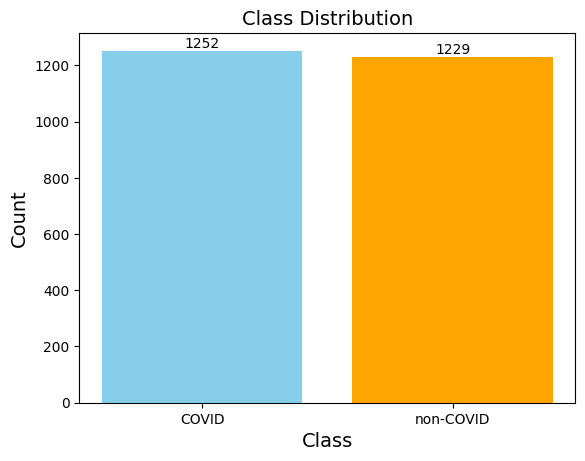

In [7]:
plot_class_distribution(data=dataset_df)

In [8]:
# Splitting dataset into Training and Test
training_df, test_df = train_test_split(dataset_df, test_size=4, shuffle=True, random_state=4)

# Save dataframe as CSV file format
csv_train_path = os.path.join(DATA_PATH, "train_data.csv")  # Training set
training_df.to_csv(path_or_buf=csv_train_path, index=False)

csv_test_path = os.path.join(DATA_PATH, "test_data.csv")  # Test set
test_df.sort_values(by=["id"], ascending=True, inplace=True)
test_df.to_csv(path_or_buf=csv_test_path, index=False)

# Read the data from the specified path 
train_data = pd.read_csv(filepath_or_buffer=TRAIN_DATA_PATH)
test_data = pd.read_csv(filepath_or_buffer=TEST_DATA_PATH)

# MobileNet

Building MobileNet model class for features extraction.

## 1. Class Structure
The `MobileNetModel` class encapsulates functionality for feature extraction using the MobileNet model. It includes attributes for the input shape, the model itself, and the output layer.

## 2. Initialization
The `__init__` method initializes the `MobileNetModel` object. It loads the MobileNet model with pre-trained weights, sets a custom name for the model, and retrieves the output layer.

## 3. Preprocessing and Loading Images
The `loading_images` method preprocesses and loads an image from the specified path. It resizes the image to match the input shape of the model, converts it to a NumPy array, adds an extra dimension for batching, and preprocesses the image according to the model's requirements.

This class provides a convenient interface for extracting features from images using the ResNet50 model.


In [9]:
class MobileNetModel:
    """
    A class for extracting features from images using the MobileNet model.
    
    Attributes:
        input_shape (tuple): The shape of the input images expected by the model.
        model (keras.Model): The MobileNet model with the fully connected layers removed.
        output (keras.layers.Layer): The output layer of the model.
    """
    def __init__(self):
        """
        Initializes the MobileNet object.
        """
        self.input_shape = INPUT_SHAPE  # Input shape
        self.model = MobileNet(weights="imagenet", input_shape=self.input_shape, include_top=False)  # Load MobileNet model with pre-trained weights
        self.model_name = "MobileNet"  # Custom name for the model
        self.model.name = self.model_name  # Set custom name for the model
        self.output = self.model.output  # Get output layer of the model
        self.model = Model(self.model.input, self.output, name=self.model_name)

    # Features extraction process
    def loading_images(self, path_to_data: str) -> np.ndarray:
        """
        Preprocesses and loads an image from the specified path.

        :param path_to_data: The path to the image file.
 
        :return numpy.ndarray: The preprocessed image as a numpy array.
        """
        # Load the image and resize it to match the input shape of the model
        x = load_img(path=path_to_data, target_size=(self.input_shape[0], self.input_shape[1])) 
        # Convert image to NumPy array
        x = img_to_array(img=x) 
        # Add an extra dimension at the beginning for batch
        x = np.expand_dims(a=x, axis=0) 
        # Preprocess the image according to the model's requirements
        x = preprocess_input(x=x)  
        
        return x

# Extraction of features from the dataset 

Extracting features from images using a provided model and saving them to a DataFrame.

## 1. Function Overview
The `extract_feature_from_data` function extracts features from images using the provided model and saves them to a DataFrame. It takes an instance of the model class for feature extraction and the path to a CSV file containing file paths and class IDs.

## 2. Data Reading
The function reads the data from the specified CSV file into a DataFrame.

## 3. Feature Extraction
For each image in the DataFrame, the function preprocesses the image and extracts features using the provided model. It prints a message indicating the file being processed and calculates the elapsed time for feature extraction.

## 4. DataFrame Creation and Saving
The extracted features, along with their corresponding class IDs, are collected into a DataFrame. The DataFrame is then saved as a CSV file for future use.

This function facilitates efficient feature extraction from images using the provided model.


In [10]:
# Extract features from images
def extract_feature_from_data(input_model, path_to_data: str) -> float:
    """
    Extract features from images using the provided model and save them to a DataFrame.
    
    Args:
    :param input_model: An instance of the model class for feature extraction.
    :param path_to_data: The path to the CSV file containing file paths and class IDs.
    
    :return pd.elapsed_time: time taken to extract features.
    """
    # Read the data from the specified path into a DataFrame
    data_df = pd.read_csv(path_to_data)
    
    # Initialize an empty list to store features
    features = []
    
    # Initialize start time
    start_time = time.time()
    
    # Iterate over each row in the DataFrame
    for file_path, label in zip(data_df.file_path, data_df.id):
        # Print a message indicating which file is being processed
        print(f"\n> Extracting features from {os.path.basename(file_path)}")
        
        # Preprocess the image and extract features using the provided model
        preprocessed_image = input_model.loading_images(path_to_data=file_path)
        feature = input_model.model.predict(preprocessed_image)[0]
        normalize_feature = feature / np.linalg.norm(feature)
        
        # Append the extracted feature along with its corresponding class id to the features list
        features.append([normalize_feature, label])
    
    # Get the model name
    model_name = input_model.model_name
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Create a DataFrame to collect model name and elapsed time and save it as a csv file
    metadata_df = pd.DataFrame({"model_name": [model_name], "time_seconds": [elapsed_time], "time_minutes": [elapsed_time/60]})
    metadata_path = os.path.join(DATA_PATH, f"{model_name}_evaluation.csv")
    metadata_df.to_csv(path_or_buf=metadata_path, index=False, float_format="%.2f")
    
    # Create a DataFrame to collect all the extracted features
    features_df = pd.DataFrame(data=features, columns=["features", "id"], index=None)
    
    # Save features to JSON file
    json_path = os.path.join(DATA_PATH, f"{model_name}_extracted_feature.json")
    features_df.to_json(json_path, orient="records")
    
    return elapsed_time
        

In [ ]:
# MobileNet model
mobilenet_model = MobileNetModel()

if not os.path.exists(MOBILENET_FEATURES_PATH):
    # Extracting features from dataset
    mobilenet_extraction_time = extract_feature_from_data(input_model=mobilenet_model, path_to_data=TRAIN_DATA_PATH)
    # Time to extract features
    print(f"\n> Extraction time: {mobilenet_extraction_time:.2f} seconds - {mobilenet_extraction_time/60:.2f} minutes") 
else:
    print(f"\n> Features already extracted and saved (location: {MOBILENET_FEATURES_PATH})")


# Image Similarity Analysis

This Markdown cell summarizes code for comparing features of images based on a chosen distance metric and finding similar images.

## 1. Finding Similar Images
The `find_similar_images` function compares features of a query image with features of all images in the dataset based on a given distance metric. It returns the indices of the most similar images and their corresponding distances.

## 2. Plotting Similar Images
The `plot_similar_images` function plots the query image along with similar images, their distances, and associated classes. It organizes the images in a grid structure with 5 images per row and saves the plot as an image file.

## 3. Choosing Query Image and Distance Metric
The `choose_query_file_and_distance` function displays available files from the test dataset and prompts the user to choose one. It also prompts the user to choose a distance metric ("Cosine", "Euclidean", or "Manhattan") for comparison.

This code facilitates the comparison and visualization of similar images based on user-defined distance metrics.


In [12]:
# Compare features based on distance metric and find similarity
def find_similar_images(features_of_query: np.array, all_features: np.array, distance_metric: str, top_n=15) -> tuple[int, int, str]:
    """
    Find similar images to the query image based on a given distance metric function.
 
    :param features_of_query: Features of the query image.
    :param all_features: Features of all images in the dataset.
    :param distance_metric: Metric to use for distance calculation. 
    Options: "Cosine", "Euclidean" or "Manhattan".
    :param top_n: Number of top similar images to consider. Default is 15.

    :return: Indices of the most similar images and their corresponding distances.
    """
    # Choose distance metric function
    if distance_metric == COSINE:
        distance_func = cosine_distances
    elif distance_metric == EUCLIDEAN:
        distance_func = euclidean_distances
    elif distance_metric == MANHATTAN:
        distance_func = manhattan_distances
    else:
        raise ValueError("Invalid distance metric. Please choose 'Cosine', 'Euclidean', 'Manhattan'.")
    
    # Reshape or flatten the query features
    if len(features_of_query.shape) > 2:
        features_of_query = features_of_query.flatten()

    # Reshape or flatten all features
    if len(all_features.shape) > 2:
        all_features = all_features.reshape(all_features.shape[0], -1)
    
    # Calculate distances between the query image features and all other images
    distances = distance_func(X=features_of_query.reshape(1, -1), Y=all_features)
    
    # Sort distances and get the indices of the closest images
    closest_indices = distances.argsort()[0][:top_n]
    closest_distances = distances[0][closest_indices]
    
    return closest_indices, closest_distances, distance_metric


# Plot similar images based on chosen distance method
def plot_similar_images(path_to_query_image: str, query_class_label: int, similar_image_paths: np.array(str), 
                        similar_class_labels: np.array(int), similar_distance_parameters:list[int], distance_metric: str) -> None:
    """
    Plot the query image along with similar images, their distances, and associated classes.

    :param path_to_query_image: File path of the query image.
    :param query_class_label: Class label of the query image.
    :param similar_image_paths: List of file paths of predicted similar images.
    :param similar_class_labels: List of predicted class labels corresponding to similar images.
    :param similar_distance_parameters: List of distance values corresponding to similar images.
    :param distance_metric: Name of the distance metric adopted.
    """
    num_similar_images = len(similar_image_paths)
    num_rows = int(np.ceil(num_similar_images / 5))  # Organize in a grid structure with 5 images per row

    # Load and display the query image separately
    plt.figure(figsize=(20, (num_rows + 1) * 4))
    
    # Add legend for distance metric and its range
    plt.subplot(num_rows + 1, 5, 1)
    plt.axis("off")
    range_text = DISTANCE_RANGES.get(distance_metric)
    if range_text is None:
        range_text = "Not specified"
    plt.text(0, 0.5, f"Legend:\n - distance: {distance_metric}\n - range: {range_text}", fontsize=16, ha="left", weight="bold", bbox=dict(facecolor="white", alpha=0.5))
    
    # Centered position for the query image
    plt.subplot(num_rows + 1, 5, 3) 
    plt.imshow(mpimg.imread(path_to_query_image))
    if query_class_label == 0:
        plt.title(f"Query Image:{os.path.basename(path_to_query_image)}\nClass: COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    else:
        plt.title(f"Query Image:{os.path.basename(path_to_query_image)}\nClass: NON COVID", fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
    plt.axis("off")

    # Plot similar images and their distances in a grid
    for figure_number, (path, similar_class, distance_parameter) in enumerate(zip(similar_image_paths, similar_class_labels, similar_distance_parameters), 1):
        plt.subplot(num_rows + 1, 5, figure_number + 5)  # Start plotting from the 2nd row
        plt.imshow(mpimg.imread(path))
        
        if similar_class == query_class_label:
            title_color = "green"
        else:
            title_color = "red"
        
        if similar_class == 0:
            plt.title(f"Image:{os.path.basename(path)}\nClass: COVID\n{distance_metric} Distance: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        else:
            plt.title(f"Image:{os.path.basename(path)}\nClass: NON COVID\n{distance_metric} Distance: {distance_parameter:.3f}", 
                      color=title_color, fontsize=14, weight="bold", bbox=dict(facecolor="lightgrey", alpha=0.5))
        plt.axis("off")
        
    plt.tight_layout()
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, f"{os.path.basename(path_to_query_image).split(".")[0]}_{distance_metric}.png") 
    plt.savefig(plot_path, dpi=96)
    
    # Display plot
    plt.show()
    

# Choose which of the images to analyze and how
def choose_query_file_and_distance(query_dataset: pd.DataFrame, select_distance: bool) -> tuple[str, int, str]:
    """
    Prompts the user to choose an image file from a dataset along with a distance function.
    
    :param query_dataset: DataFrame containing image file paths and labels.
    :param select_distance: If True, prompts for selecting both an image file and a distance function. 
            If False, only prompts for selecting an image file.

    :returns: 'query_file_path': query file path. 
             'query_id': query corresponding class label.
             'distance_func': chosen distance function by the user.
    """
    query_file_path = str
    query_id = id
    distance_func = str
    
    # Construct the prompt message for file selection
    file_names = [os.path.basename(path) for path in query_dataset["file_path"]]
    file_prompt_message = (f"Enter the index of the file you want to choose.\n"
                           f"Options:\n\n[index - file]\n")
    for i, file_name in enumerate(file_names):
        file_prompt_message += f"{i}\t-\t{file_name}\n"
    
    while True:
        file_choice = input(file_prompt_message)
        if file_choice.strip() == "":
            print("No input provided. Please enter a valid index!")
            continue
        
        try:
            file_choice = int(file_choice)
            if file_choice < 0 or file_choice >= len(query_dataset):
                print("Invalid index. Please choose a valid index!")
                continue
            else:
                query_file_path = query_dataset.iloc[file_choice]["file_path"]
                query_id = query_dataset.iloc[file_choice]["id"]
                break
        except ValueError:
            print("Invalid input. Please enter a valid index!")
    
    # If select_distance is True, prompt for distance function selection
    if select_distance:
        # Construct the prompt message for distance function selection
        distance_prompt_message = ("Choose the distance function:\n"
                                   "1 - Cosine\n"
                                   "2 - Euclidean\n"
                                   "3 - Manhattan\n")

        while True:
            distance_choice = input(distance_prompt_message)
            if distance_choice not in {"1", "2", "3"}:
                print("Invalid choice. Please enter a valid number!")
                continue
            else:
                if distance_choice == "1":
                    distance_func = "Cosine"
                elif distance_choice == "2":
                    distance_func = "Euclidean"
                elif distance_choice == "3":
                    distance_func = "Manhattan"
                break
    
    return query_file_path, query_id, distance_func


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

> Query image: archives/COVID/Covid (229).png
> Class label: 0


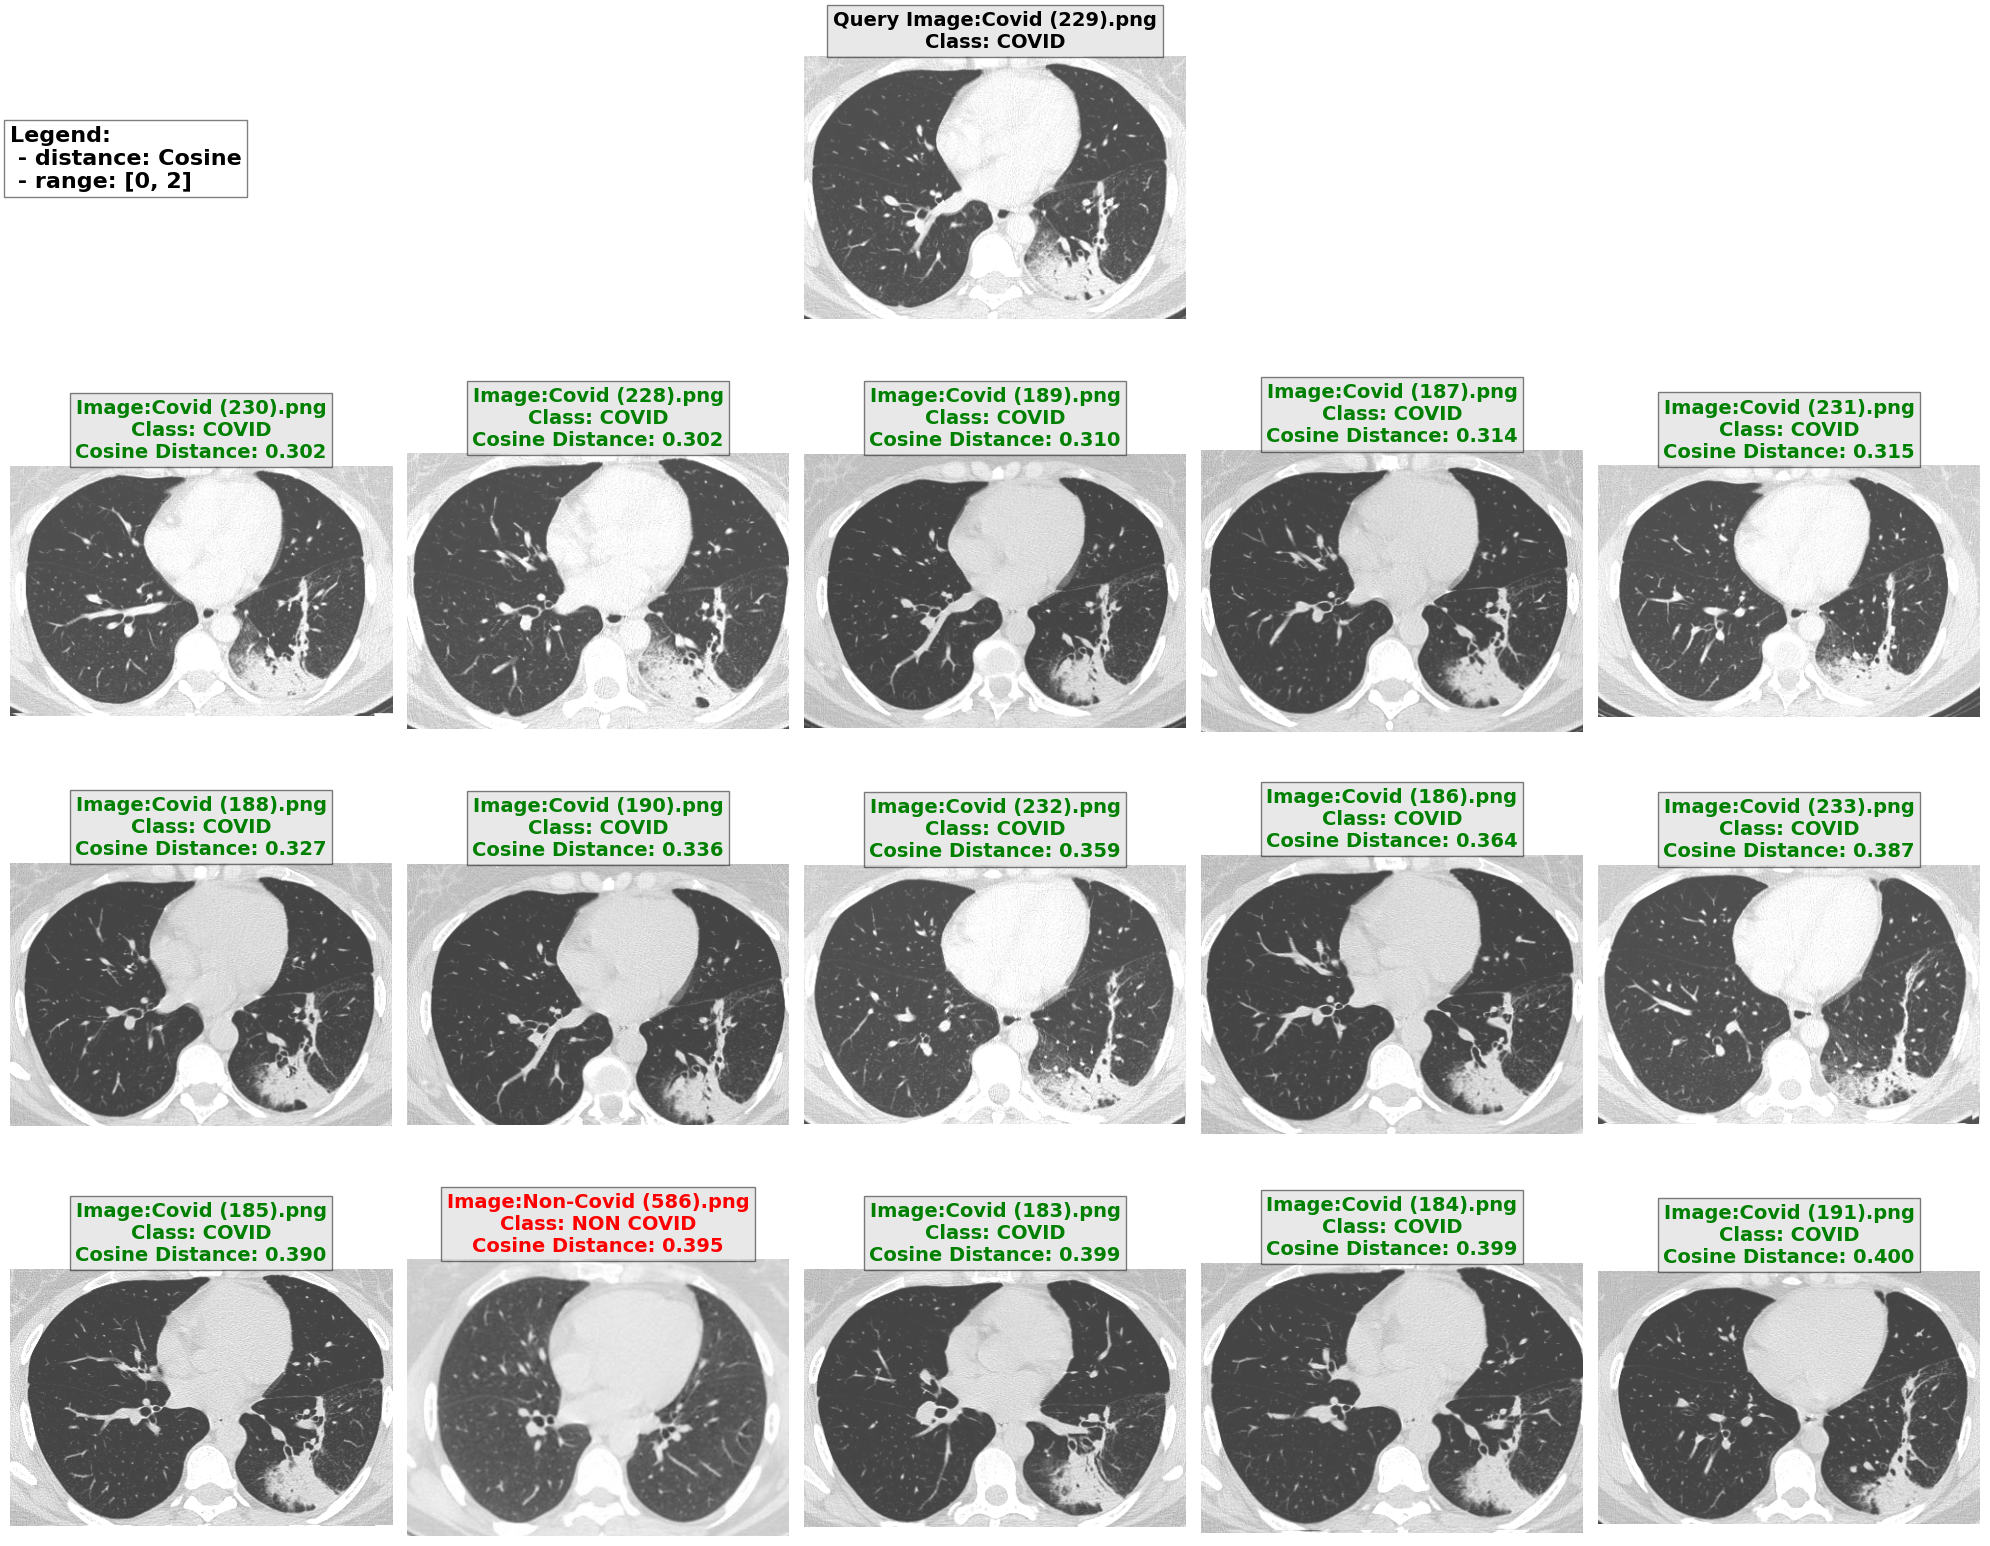

In [13]:
## ************************************ MOBILENET - FROM QUERY FIND SIMILAR ********************************** ##

# Load the features data from the JSON file
mobilenet_features_dataframe = pd.read_json(path_or_buf=MOBILENET_FEATURES_PATH)

# Read the data from the specified path 
train_data = pd.read_csv(filepath_or_buffer=TRAIN_DATA_PATH)
test_data = pd.read_csv(filepath_or_buffer=TEST_DATA_PATH)

# Choose a file from the test dataset
chosen_file_path, chosen_id, distance = choose_query_file_and_distance(query_dataset=test_data, select_distance=True)

# Load the query image
mobilenet_query_features = mobilenet_model.loading_images(path_to_data=chosen_file_path)
mobilenet_query_features = mobilenet_model.model.predict(x=mobilenet_query_features)[0]
mobilenet_query_features = mobilenet_query_features / np.linalg.norm(x=mobilenet_query_features)

# Separate features and labels
mobilenet_all_features = np.array(mobilenet_features_dataframe["features"].to_list())

# Calculate cosine distances and find similar images
similar_indices, similar_distances, function = find_similar_images(features_of_query=mobilenet_query_features, 
                                                                   all_features=mobilenet_all_features, 
                                                                   distance_metric=distance)

# Print info. about query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Class label: {chosen_id}")

# Lists of similar image found and corresponding true labels
similar_images = [train_data.iloc[index]["file_path"] for index in similar_indices]
similar_labels = np.array([train_data.iloc[index]["id"] for index in similar_indices])


# Plot similar images with classes
plot_similar_images(path_to_query_image=chosen_file_path, 
                    query_class_label=chosen_id, 
                    similar_image_paths=similar_images,
                    similar_class_labels=similar_labels, 
                    similar_distance_parameters=similar_distances,
                    distance_metric=function)


# Compute evaluation metrics scores

It computes precision, recall, and F1-score for each distance metric and prints the evaluation metrics. 

In [14]:
# Precision score
def precision_score(query_label: int, y_true: np.array, y_pred: np.array) -> float:
    """
    Compute precision score.

    :param query_label: Chosen image ID.
    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.

    :return: Precision score.
    """
    true_positives = int
    false_positives = int

    if query_label == 0:  # COVID
        true_positives = np.sum((y_true == 0) & (y_pred == 0))
        false_positives = np.sum((y_true == 1) & (y_pred == 0))
    elif query_label == 1:  # non-COVID
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))

    if true_positives + false_positives == 0:
        return 0.0

    precision = true_positives / (true_positives + false_positives)
    
    return precision


# Recall score
def recall_score(query_label: int, y_true: np.array, y_pred: np.array) -> float:
    """
    Compute recall score.

    :param query_label: Chosen image ID.
    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.

    :return: Recall score.
    """
    true_positives = int
    false_negatives = int

    if query_label == 0:  # COVID
        true_positives = np.sum((y_true == 0) & (y_pred == 0))
        false_negatives = np.sum((y_true == 0) & (y_pred == 1))
    elif query_label == 1:  # non-COVID
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))

    if true_positives + false_negatives == 0:
        return 0.0

    recall = true_positives / (true_positives + false_negatives)
    
    return recall


# F1-score 
def f1_score(computed_precision: float, computed_recall: float) -> float:
    """
    Compute F1-score.

    :param computed_precision: computed precision score.
    :param computed_recall: computed recall score.

    :return: F1-score.
    """
    if computed_precision + computed_recall == 0:
        return 0.0

    f1 = 2 * (computed_precision * computed_recall) / (computed_precision + computed_recall)
    
    return f1


In [15]:
# Evaluation of the model performance
def evaluate_similarity(query_img_features: np.array, query_img_id: int, all_features: np.array, top_n=100) -> tuple[float, float, float]:
    """
    Evaluate the similarity between the query image and all other images in the dataset.

    :param query_img_features: Features of the query image.
    :param query_img_id: ID of the query image.
    :param all_features: Features of all images in the dataset.
    :param top_n: Number of top similar images to consider for top-N accuracy.

    :return: precision, recall, F1-score.
    """
    # Reshape or flatten the query features
    if len(query_img_features.shape) > 2:
        query_img_features = query_img_features.flatten()
    
    # Reshape or flatten all features
    if len(all_features.shape) > 2:
        all_features = all_features.reshape(all_features.shape[0], -1)
    
    for distance_metric in [COSINE, EUCLIDEAN, MANHATTAN]:
        # Calculate distances between the query image features and all other images
        if distance_metric == COSINE:
            distances = cosine_distances(query_img_features.reshape(1, -1), all_features)
        elif distance_metric == EUCLIDEAN:
            distances = euclidean_distances(query_img_features.reshape(1, -1), all_features)
        elif distance_metric == MANHATTAN:
            distances = manhattan_distances(query_img_features.reshape(1, -1), all_features)
        else:
            raise ValueError("Invalid distance metric. Choose from 'Cosine', 'Euclidean', 'Manhattan'.")

        # Sort distances and get the indices of the closest top_n images
        closest_indices = distances.argsort()[0][:top_n]

        # Extract labels for the top similar images
        retrieved_labels = np.array([train_data.iloc[index]["id"] for index in closest_indices])
        
        # Predictions -> the top_n retrieved elements are considered belonging to the query class label
        predicted_labels = np.array([query_img_id] * len(retrieved_labels))
        
        # Compute metrics
        precision = precision_score(query_label=query_img_id, y_true=retrieved_labels, y_pred=predicted_labels)
        recall = recall_score(query_label=query_img_id, y_true=retrieved_labels, y_pred=predicted_labels)
        f1 = f1_score(computed_precision=precision, computed_recall=recall)
        
        return precision, recall, f1


In [16]:
## ************************************ COMPUTE THE EVALUATION METRICS ********************************** ##

# Choose a file from the test dataset
chosen_file_path, chosen_id, _ = choose_query_file_and_distance(query_dataset=test_data, select_distance=False)

# Print info. about query
print(f"\n> Query image: {chosen_file_path}"
      f"\n> Class label: {chosen_id}")

# Load the query image
query = mobilenet_model.loading_images(path_to_data=chosen_file_path)
query = mobilenet_model.model.predict(x=query)[0]
query = query / np.linalg.norm(x=query)

# Evaluate the performance of the model
precision_score_value, recall_score_value, f1_score_value = evaluate_similarity(query_img_features=query, 
                                                                                query_img_id=chosen_id, 
                                                                                all_features=mobilenet_all_features, 
                                                                                top_n=100)

# Print Evaluation scores
print(f"\n> Evaluation score:")
print(f"-- Precision score: {precision_score_value:.3f}")
print(f"-- Recall score: {recall_score_value:.3f}")
print(f"-- F1-score: {f1_score_value:.3f}")



> Query image: archives/COVID/Covid (229).png
> Class label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

> Evaluation score:
-- Precision score: 0.670
-- Recall score: 1.000
-- F1-score: 0.802


# Models Evaluation 

In [17]:
# Evaluation of the model performances
def model_evaluation(input_model, test_dataset: pd.DataFrame, model_extracted_features: np.ndarray):
    
    all_precision = []
    all_recall = []
    all_f1 = []
    
    # Loop through the test dataset
    for query_path, query_id in zip(test_dataset["file_path"], test_dataset["id"]):
         
        # Load the query image and extract features
        query_features = input_model.loading_images(path_to_data=query_path)
        query_features = input_model.model.predict(x=query_features)[0]
        query_features = query_features / np.linalg.norm(x=query_features)
        
        # Compute evaluation metrics: precision, recall and f1-score
        model_precision, model_recall, model_f1 = evaluate_similarity(query_img_features=query_features, 
                                                                      query_img_id=query_id, 
                                                                      all_features=model_extracted_features, 
                                                                      top_n=100)
        # Append values
        all_precision.append(model_precision)
        all_recall.append(model_recall)
        all_f1.append(model_f1)
        
    mean_precision = np.mean(all_precision, axis=0)
    mean_recall = np.mean(all_recall, axis=0)
    mean_f1 = np.mean(all_f1, axis=0)
    
    # Load CSV file
    evaluation_file_path = os.path.join(DATA_PATH, f"{input_model.model_name}_evaluation.csv")
    evaluation_df = pd.read_csv(filepath_or_buffer=evaluation_file_path)
    
    # Add new columns to the existing DataFrame
    evaluation_df["mean_precision"] = mean_precision
    evaluation_df["mean_recall"] = mean_recall
    evaluation_df["mean_f1"] = mean_f1
    
    # Save the updated DataFrame back to CSV
    evaluation_df.to_csv(evaluation_file_path, index=False, float_format="%.3f")
    
    return mean_precision, mean_recall, mean_f1
    
    
## ************************************ COMPUTE THE EVALUATION METRICS ********************************** ##


# MobileNet Evaluation
mobilenet_average_precision, mobilenet_average_recall, mobilenet_average_f1 = model_evaluation(input_model=mobilenet_model, test_dataset=test_data, 
                                                                                               model_extracted_features=mobilenet_all_features)

# Print Evaluation scores
print(f"\n> MobileNet Average evaluation:")
print(f"-- Precision: {mobilenet_average_precision:.3f}")
print(f"-- Recall: {mobilenet_average_recall:.3f}")
print(f"-- F1-score: {mobilenet_average_f1:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

> MobileNet Average evaluation:
-- Precision: 0.643
-- Recall: 1.000
-- F1-score: 0.767
